In [1]:
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
import researchpy as rp
from statsmodels.formula.api import ols
import warnings

# Supress unwanted errors from script output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Manually define a tab variable because \t isn't working right
# And I don't want to take the time to figure out why, when I can brute force it :)
tab = "        "

# Import data after exclusion from csv
df = pd.read_csv("/workspaces/codespaces-blank/data/final-dataset-aaa26.csv")

In [2]:
# Apply general table formatting to Table plots
def format_table(data, title, fig_height=1):
    data = data.round(4)
    fig, ax = plt.subplots(figsize=(10, fig_height))
    ax.axis("off")
    ax.set_title(title)
    table = ax.table(cellText = data.values, colLabels=data.columns, loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(list(range(len(data.columns))))
    table.scale(1.2, 1.2)

    plt.show()


# Define variable calculations for ANOVA equation and table formatting
def anova_table(aov, title="One-Way ANOVA, Type II", fig_height=1):
    aov['mean_sq'] = aov[:]['sum_sq'] / aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq'] / sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq'] - (aov[:-1]['df'] * aov['mean_sq'][-1])) / (sum(aov['sum_sq']) + aov['mean_sq'][-1])
    cols = ["sum_sq", "df", "mean_sq", "F", "PR(>F)", "eta_sq", "omega_sq"]
    aov = aov[cols]

    format_table(aov, title, fig_height)


# Standardized function to generate table plots of analyses vs printing to console
# ==============================
# dvar: string, column name of the dependent variable
# ivar: string, column name of the independent variable
# method: string, name of the desired allpairtest() method; currently only "bonf" and "sidak" are valid
# a: float, alpha value; default is 0.05
# fig_height: int, desired height of table subplot; default is 1
def t_table(dvar, ivar, method, a=0.05, fig_height=1):
    # Initialize required data to generate figures/tables
    t_comp = mc.MultiComparison(dvar, ivar)
    t_tbl, t_a1, t_a2 = t_comp.allpairtest(stats.ttest_ind, alpha=a, method=method)
    t_df = pd.DataFrame(t_a2)

    # Calculate group sample sizes and insert into t_table
    n_g1 = [f"{len(dvar[ivar == i])}" for i in t_df['group1'].values]
    n_g2 = [f"{len(dvar[ivar == i])}" for i in t_df['group2'].values]
    t_df.insert(1, "n, group1", n_g1)
    t_df.insert(3, "n, group2", n_g2)

    # Format the plot area
    t_title = f"Test Multiple Comparison ttest_ind"
    t_title += f"\nFWER = 0.05{tab}Method = {method}"
    t_title += f"\n{dvar.name} ~ {ivar.name}"
    format_table(t_df, t_title, fig_height)


# Standardized function to generate a figureset for a single dependent/independent variables. 
# Independent variables can be iterated through to generate all plots with one function call
# ==============================
# frame: pd.DataFrame()
# dcol: string, column name of the dependent variable
# icol: string, column name of the independent variable
def GeneratePlots(frame, dcol, icol):
    # Initialize instance variables
    dv = frame.get(dcol)
    iv = frame.get(icol)
    dvlabel = dcol.replace("_", " ")
    ivlabel = icol.replace("_", " ")
    ivals = iv.unique().tolist()
    anova_model = ols(f"{dcol} ~ C({icol})", data=frame).fit()
    
    # Generate Probability Plot
    prob_fig = plt.figure(figsize=(10, 10))
    prob_ax = prob_fig.add_subplot(111)
    normality_plot, stat = stats.probplot(anova_model.resid, plot=plt, rvalue=True)
    prob_ax.set_title(f"Probability Plot of {ivlabel} Residuals")
    prob_ax.set
    plt.show()

    # Generate Box Plot
    box_fig = plt.figure(figsize=(10, 10))
    box_ax = box_fig.add_subplot(111)
    box_ax.set_title(f"Box Plot of {dvlabel} by {ivlabel}", fontsize=20)
    box_ax.set
    data = [dv[iv == i] for i in ivals]
    box_ax.boxplot(data, tick_labels=[f"{i}\n$n$={len(dv[iv == i])}" for i in ivals], showmeans=True)
    plt.xlabel(ivlabel)
    plt.ylabel(dvlabel)
    plt.show()

    # Generate ANOVA Table
    aov2_table = sm.stats.anova_lm(anova_model, typ=2)
    aov2_title = f"One-Way ANOVA, Type II\n{dcol} ~ {icol}"
    anova_table(aov2_table, aov2_title, fig_height=2)

    # Generate Tukey HSD Table
    comp = mc.MultiComparison(dv, iv)
    post_hoc_res = comp.tukeyhsd()
    post_hoc_res.plot_simultaneous(ylabel=dvlabel, xlabel="Score Difference")

    # Generate T-Test Tables
    t_table(dv, iv, method="bonf", fig_height=2)
    t_table(dv, iv, method="sidak", fig_height=2)

    # Run tests and create arrays of values
    sw_statistic, sw_p_value = stats.shapiro(anova_model.resid)
    sw = pd.Series(["Shapiro-Wilk Test", sw_statistic, sw_p_value])
    kw_statistic, kw_p_value = stats.kruskal(*[dv[iv == i] for i in ivals])
    kw = pd.Series(["Kruskal-Wallis Test", kw_statistic, kw_p_value])
    std_statistic, std_p_value = stats.f_oneway(*[dv[iv == i] for i in ivals], equal_var=True)
    std = pd.Series(["One-Way ANOVA Test", std_statistic, std_p_value])
    w_statistic, w_p_value = stats.f_oneway(*[dv[iv == i] for i in ivals], equal_var=False)
    w = pd.Series(["Welch's ANOVA Test", w_statistic, w_p_value])
    bf_statistic, bf_p_value = stats.levene(*[dv[iv == i] for i in ivals])
    bf = pd.Series(["Brown-Forsythe Test", bf_statistic, bf_p_value])

    # Initialize Dataframe of test results
    sf = pd.DataFrame([sw.values, kw.values, std.values, w.values, bf.values], columns=["Test", "Statistic", "P-value"])
    sf_title = (f"Statistical Test Summary\n{dvlabel} ~ {ivlabel}")
    format_table(sf, sf_title, fig_height=2)

    return

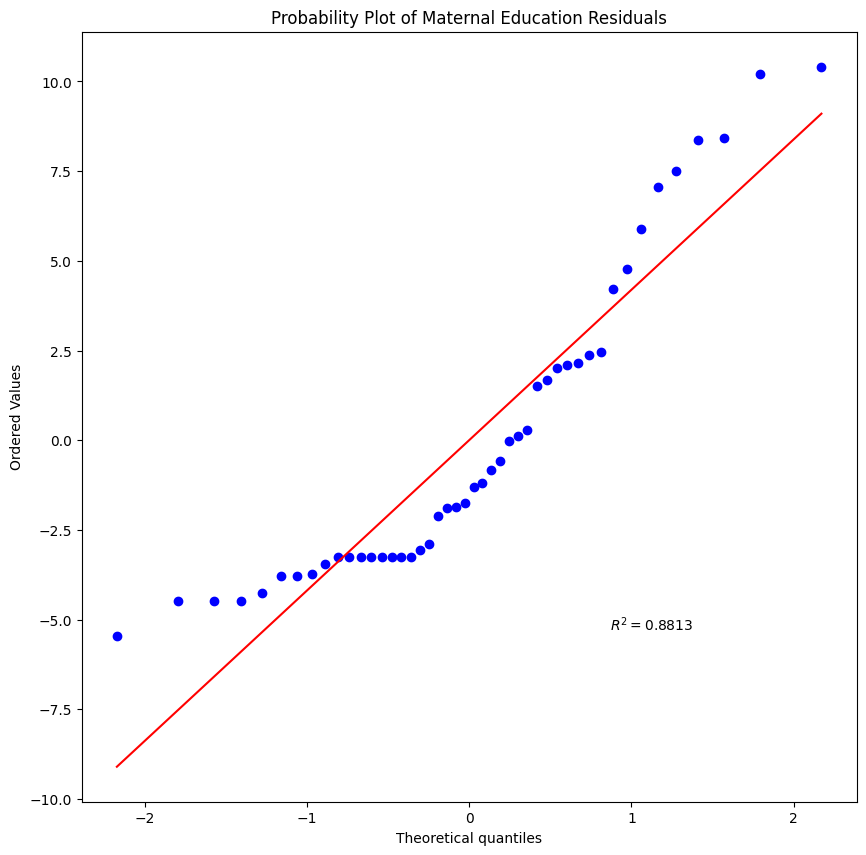

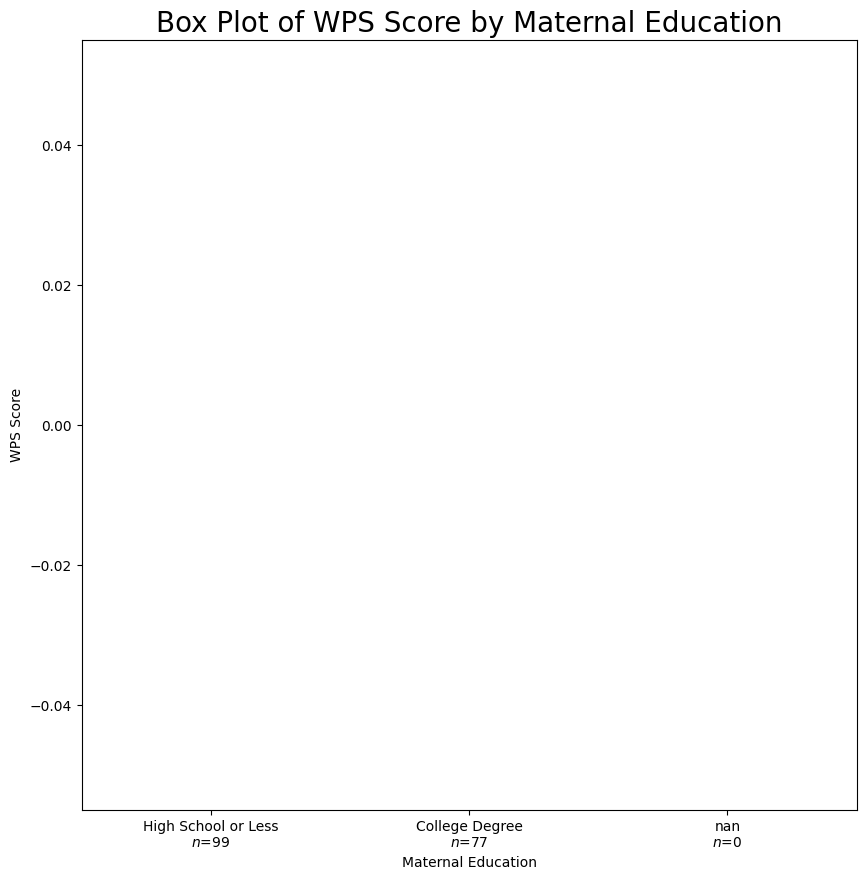

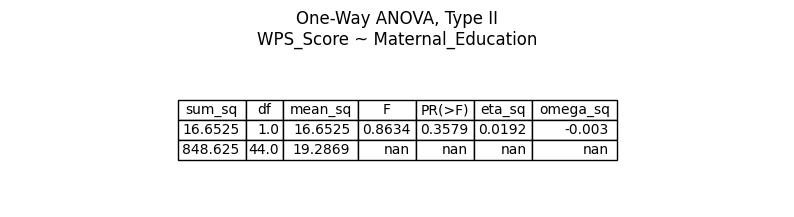

TypeError: '<' not supported between instances of 'str' and 'float'

In [3]:
GeneratePlots(df, "WPS_Score", "Maternal_Education")

In [ ]:
GeneratePlots(data, "WPS_Score", "Indicator_SLD_Or_ADHD")